# Import necessary packages

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import keras
import os

# For data preparation and cleaning
import re
import string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# to load the dataset
from tensorflow.keras.preprocessing import text_dataset_from_directory

# to create the DL model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras import losses

In [ ]:
dataset_dir = "./Dataset/original/aclImdb"
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(train_dir)

['urls_unsup.txt',
 'urls_pos.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'neg',
 'pos']

## Load Dataset

In [ ]:
batch_size = 50
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.1, 
    subset='training', 
    seed=seed
)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.1, 
    subset='validation', 
    seed=seed
)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size,
    seed=seed
)


Found 25000 files belonging to 2 classes.
Using 22500 files for training.
Found 25000 files belonging to 2 classes.
Using 2500 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


# Prepare Dataset for training

## Remove HTML Tag

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

## Standardize, tokenize, and vectorize the data

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

#### Note:
The next step will adapt the TextVectorization layer to map the text into integers. It performs data cleaning first on the text, by lowercasing all the letters, then standardize the text to finally tokenize it.

This operation took 30 min.

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

## Example of vectorization

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]

print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Prominent attorney Walter Pidgeon takes a murder case pro bono, wins an acquittal and discovers that his client (Keefe Braselle) was not only guilty but part of an extortion ring reaching to the highest eschelons of the city. Panged by his own complicity, he undertakes an investigation, stumbles onto the identity of the "unknown man" who heads the syndicate, and murders him.<br /><br />The ironies engage when Braselle is charged with this second murder and Pidgeon must defend him by pointing to the existence of another "unknown man" -- himself. Though somewhat short of urban grit and long on rhetoric, the Unknown Man belongs to the noir cycle less by style or structure than by its acknowledgement of the pervasive corruption of American municipal politics that came to light in the postwar years.', shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[5711, 5036, 2246,    1,  294,    4,  582,  407, 5533,    1, 2769

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  nobody
 313 --->  american
Vocabulary size: 10000


## Vectorization on train,validation and test datasets

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Cache and Prefetch the data for better performance

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for x in train_ds.take(1):
  print(x)

(<tf.Tensor: shape=(50, 250), dtype=int64, numpy=
array([[   2,   17, 3758, ...,    6,    1,   23],
       [ 397,    4,  775, ...,    0,    0,    0],
       [   2, 1086,    5, ...,   16,   23,    1],
       ...,
       [  10,   41,  181, ...,    0,    0,    0],
       [ 870,  613,  400, ...,  148,  802,   38],
       [  10,   25,    6, ...,    0,    0,    0]])>, <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1], dtype=int32)>)


# Building the model

In [ ]:
embedding_dim = 20

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Bidirectional(layers.LSTM(20, return_sequences=True,dropout=0.6, activity_regularizer=l2(0.01))),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1,activation="sigmoid")])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 20)          200020    
                                                                 
 dropout_2 (Dropout)         (None, None, 20)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 40)         6560      
 nal)                                                            
                                                                 
 global_average_pooling1d_1   (None, 40)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

In [ ]:
epochs = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/40
450/450 [==============================] - 834s 2s/step - loss: 0.6547 - binary_accuracy: 0.5695 - val_loss: 0.5824 - val_binary_accuracy: 0.6780
Epoch 2/40
450/450 [==============================] - 9s 19ms/step - loss: 0.5226 - binary_accuracy: 0.8326 - val_loss: 0.4896 - val_binary_accuracy: 0.8664
Epoch 3/40
450/450 [==============================] - 8s 19ms/step - loss: 0.4380 - binary_accuracy: 0.8921 - val_loss: 0.4543 - val_binary_accuracy: 0.8740
Epoch 4/40
450/450 [==============================] - 8s 19ms/step - loss: 0.3895 - binary_accuracy: 0.9104 - val_loss: 0.4207 - val_binary_accuracy: 0.8752
Epoch 5/40
450/450 [==============================] - 9s 19ms/step - loss: 0.3549 - binary_accuracy: 0.9204 - val_loss: 0.4311 - val_binary_accuracy: 0.8720
Epoch 6/40
450/450 [==============================] - 9s 19ms/step - loss: 0.3394 - binary_accuracy: 0.9212 - val_loss: 0.4111 - val_binary_accuracy: 0.8676
Epoch 7/40
450/450 [==============================] - 9s 1

## Plot accuracy and Loss

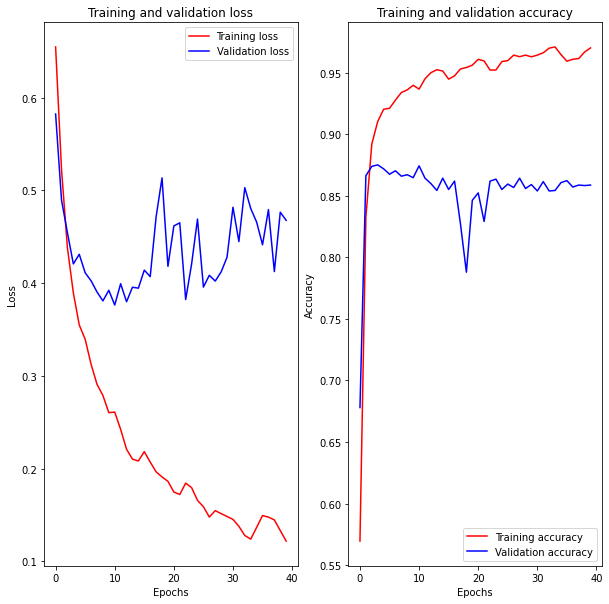

In [ ]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']


epochs_list = range(epochs)

fig, axes = plt.subplots(1,2,figsize=(10,10))

# Loss 
axes[0].plot(epochs_list, loss, 'r', label='Training loss')
axes[0].plot(epochs_list, val_loss, 'b', label='Validation loss')
axes[0].set_title('Training and validation loss')

axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# accuracy
axes[1].plot(epochs_list, acc, 'r', label='Training accuracy')
axes[1].plot(epochs_list, val_acc, 'b', label='Validation accuracy')
axes[1].set_title('Training and validation accuracy')

axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

## Evaluate model on test dataset

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

500/500 [==============================] - 9533s 19s/step - loss: 0.5437 - binary_accuracy: 0.8361
Loss:  0.543701171875
Accuracy:  0.836080014705658


## Saving the Rnn model

In [ ]:
model.save('./models/DL_solution/rnn_model_1.h5')

## Save the model with the vectorization layer

Saving the model with the vectorization layer, helps using the model on raw text

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)# Test it with `raw_test_ds`, which yields raw strings

export_model.save('./models/DL_solution/rnn_with_vectorization')

### Prediction in text

In [ ]:
test_reviews = [
  "The movie was great!",
  "The movie was excellent",
  "The movie was outstanding. I would like to watch again...",
  "The movie was terrible... total waste of money..."
]

In [ ]:
export_model.predict(test_reviews)

array([[0.8716313 ],
       [0.888394  ],
       [0.7556651 ],
       [0.02419949]], dtype=float32)